# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.04245569, -0.19797182,  0.03782231,  0.25677633]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.7618205522030155 -2.8073024267797293


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [12]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    return states, actions

In [13]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [14]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                     labels=actions_labels))        
    return actions_logits, loss

In [15]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [18]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [19]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
env.reset()

array([0.03773464, 0.00522786, 0.02775851, 0.01275922])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
state, reward, action

(array([-0.17317995, -1.41436692,  0.20208303,  2.19573337]), 1.0, 0)

In [33]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward # last action is always 0
            batch.append([state, action])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                 model.actions: actions})
            
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode: 0 Total reward: 9 Batch loss: 0.641246378
Episode: 1 Total reward: 9 Batch loss: 0.624288023
Episode: 2 Total reward: 11 Batch loss: 0.581499517
Episode: 3 Total reward: 9 Batch loss: 0.593236804
Episode: 4 Total reward: 10 Batch loss: 0.557814598
Episode: 5 Total reward: 10 Batch loss: 0.549390614
Episode: 6 Total reward: 8 Batch loss: 0.579835415
Episode: 7 Total reward: 10 Batch loss: 0.538655579
Episode: 8 Total reward: 10 Batch loss: 0.523155928
Episode: 9 Total reward: 10 Batch loss: 0.517527759
Episode: 10 Total reward: 9 Batch loss: 0.532377362
Episode: 11 Total reward: 9 Batch loss: 0.532347381
Episode: 12 Total reward: 8 Batch loss: 0.550836563
Episode: 13 Total reward: 9 Batch loss: 0.527757645
Episode: 14 Total reward: 9 Batch loss: 0.520011663
Episode: 15 Total reward: 11 Batch loss: 0.485497504
Episode: 16 Total reward: 10 Batch loss: 0.498599291
Episode: 17 Total reward: 9 Batch loss: 0.511503756
Episode: 18 Total reward: 9 Batch loss: 0.505565643
Episode: 19 To

Episode: 158 Total reward: 28 Batch loss: 0.156343728
Episode: 159 Total reward: 28 Batch loss: 0.132885829
Episode: 160 Total reward: 28 Batch loss: 0.134905741
Episode: 161 Total reward: 32 Batch loss: 0.271798611
Episode: 162 Total reward: 21 Batch loss: 0.142229825
Episode: 163 Total reward: 28 Batch loss: 0.134209543
Episode: 164 Total reward: 30 Batch loss: 0.119853981
Episode: 165 Total reward: 24 Batch loss: 0.129008159
Episode: 166 Total reward: 34 Batch loss: 0.111326426
Episode: 167 Total reward: 34 Batch loss: 0.114798956
Episode: 168 Total reward: 23 Batch loss: 0.173422053
Episode: 169 Total reward: 30 Batch loss: 0.113224559
Episode: 170 Total reward: 29 Batch loss: 0.127989024
Episode: 171 Total reward: 36 Batch loss: 0.101401664
Episode: 172 Total reward: 33 Batch loss: 0.125097796
Episode: 173 Total reward: 34 Batch loss: 0.118313707
Episode: 174 Total reward: 36 Batch loss: 0.108707994
Episode: 175 Total reward: 30 Batch loss: 0.097790517
Episode: 176 Total reward: 2

Episode: 311 Total reward: 141 Batch loss: 0.226587012
Episode: 312 Total reward: 69 Batch loss: 0.060932513
Episode: 313 Total reward: 73 Batch loss: 0.067962252
Episode: 314 Total reward: 81 Batch loss: 0.063722067
Episode: 315 Total reward: 107 Batch loss: 0.052177023
Episode: 316 Total reward: 89 Batch loss: 0.060321610
Episode: 317 Total reward: 131 Batch loss: 0.209211677
Episode: 318 Total reward: 89 Batch loss: 0.055315070
Episode: 319 Total reward: 64 Batch loss: 0.065375060
Episode: 320 Total reward: 179 Batch loss: 0.241922095
Episode: 321 Total reward: 65 Batch loss: 0.057539519
Episode: 322 Total reward: 111 Batch loss: 0.038101248
Episode: 323 Total reward: 70 Batch loss: 0.097969830
Episode: 324 Total reward: 70 Batch loss: 0.077835530
Episode: 325 Total reward: 85 Batch loss: 0.055342574
Episode: 326 Total reward: 123 Batch loss: 0.038462196
Episode: 327 Total reward: 67 Batch loss: 0.060218062
Episode: 328 Total reward: 71 Batch loss: 0.054433886
Episode: 329 Total rew

Episode: 462 Total reward: 200 Batch loss: 0.140378892
Episode: 463 Total reward: 200 Batch loss: 0.129523471
Episode: 464 Total reward: 200 Batch loss: 0.308079600
Episode: 465 Total reward: 200 Batch loss: 0.222273499
Episode: 466 Total reward: 200 Batch loss: 0.249275193
Episode: 467 Total reward: 200 Batch loss: 0.108536817
Episode: 468 Total reward: 200 Batch loss: 0.145693272
Episode: 469 Total reward: 200 Batch loss: 0.293659896
Episode: 470 Total reward: 200 Batch loss: 0.266481221
Episode: 471 Total reward: 200 Batch loss: 0.284038246
Episode: 472 Total reward: 200 Batch loss: 0.265148193
Episode: 473 Total reward: 200 Batch loss: 0.291510999
Episode: 474 Total reward: 200 Batch loss: 0.134822085
Episode: 475 Total reward: 200 Batch loss: 0.213765278
Episode: 476 Total reward: 200 Batch loss: 0.335949332
Episode: 477 Total reward: 200 Batch loss: 0.161783829
Episode: 478 Total reward: 200 Batch loss: 0.236513764
Episode: 479 Total reward: 200 Batch loss: 0.271653146
Episode: 4

Episode: 611 Total reward: 200 Batch loss: 0.191425502
Episode: 612 Total reward: 200 Batch loss: 0.172464237
Episode: 613 Total reward: 200 Batch loss: 0.226816088
Episode: 614 Total reward: 200 Batch loss: 0.264301270
Episode: 615 Total reward: 200 Batch loss: 0.122060448
Episode: 616 Total reward: 200 Batch loss: 0.231609911
Episode: 617 Total reward: 200 Batch loss: 0.337293237
Episode: 618 Total reward: 200 Batch loss: 0.225452915
Episode: 619 Total reward: 200 Batch loss: 0.196069032
Episode: 620 Total reward: 200 Batch loss: 0.201373100
Episode: 621 Total reward: 200 Batch loss: 0.226356894
Episode: 622 Total reward: 200 Batch loss: 0.199094102
Episode: 623 Total reward: 200 Batch loss: 0.320316166
Episode: 624 Total reward: 200 Batch loss: 0.338871151
Episode: 625 Total reward: 200 Batch loss: 0.267096430
Episode: 626 Total reward: 200 Batch loss: 0.334243059
Episode: 627 Total reward: 200 Batch loss: 0.297610760
Episode: 628 Total reward: 200 Batch loss: 0.259102523
Episode: 6

Episode: 760 Total reward: 200 Batch loss: 0.195615754
Episode: 761 Total reward: 200 Batch loss: 0.178279951
Episode: 762 Total reward: 200 Batch loss: 0.207986578
Episode: 763 Total reward: 200 Batch loss: 0.294867188
Episode: 764 Total reward: 200 Batch loss: 0.257795364
Episode: 765 Total reward: 200 Batch loss: 0.289501190
Episode: 766 Total reward: 200 Batch loss: 0.195918575
Episode: 767 Total reward: 200 Batch loss: 0.275557727
Episode: 768 Total reward: 200 Batch loss: 0.228963047
Episode: 769 Total reward: 200 Batch loss: 0.219603956
Episode: 770 Total reward: 200 Batch loss: 0.287219465
Episode: 771 Total reward: 200 Batch loss: 0.284600437
Episode: 772 Total reward: 200 Batch loss: 0.198525622
Episode: 773 Total reward: 200 Batch loss: 0.222877070
Episode: 774 Total reward: 200 Batch loss: 0.197000012
Episode: 775 Total reward: 200 Batch loss: 0.212743834
Episode: 776 Total reward: 200 Batch loss: 0.227956310
Episode: 777 Total reward: 200 Batch loss: 0.280747741
Episode: 7

Episode: 909 Total reward: 200 Batch loss: 0.184763089
Episode: 910 Total reward: 200 Batch loss: 0.237981915
Episode: 911 Total reward: 200 Batch loss: 0.185275540
Episode: 912 Total reward: 200 Batch loss: 0.221189141
Episode: 913 Total reward: 200 Batch loss: 0.236996263
Episode: 914 Total reward: 200 Batch loss: 0.204061314
Episode: 915 Total reward: 200 Batch loss: 0.171496540
Episode: 916 Total reward: 200 Batch loss: 0.238162160
Episode: 917 Total reward: 200 Batch loss: 0.168873668
Episode: 918 Total reward: 200 Batch loss: 0.155338645
Episode: 919 Total reward: 200 Batch loss: 0.190017849
Episode: 920 Total reward: 200 Batch loss: 0.172733009
Episode: 921 Total reward: 200 Batch loss: 0.129718289
Episode: 922 Total reward: 200 Batch loss: 0.163888976
Episode: 923 Total reward: 200 Batch loss: 0.154610932
Episode: 924 Total reward: 200 Batch loss: 0.224002421
Episode: 925 Total reward: 200 Batch loss: 0.154750019
Episode: 926 Total reward: 200 Batch loss: 0.157724306
Episode: 9

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

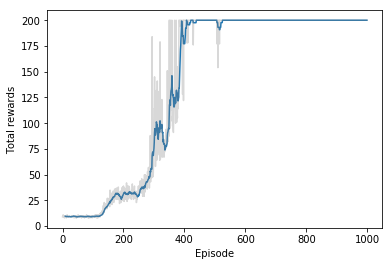

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

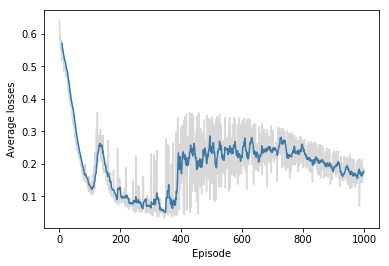

In [42]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [48]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.